In [ ]:
#importing libraries
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import umap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

In [ ]:
#Load train and test files

train =  pd.read_table('medisyn-labs/train.tsv',sep='\t', header=None)
test = pd.read_table('medisyn-labs/test.tsv',sep='\t', header=None)

In [ ]:
train.head()

,0,1,2,3,4,5,6,7,8
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [ ]:
### Adding headers to train and test files
train.columns = ['Customer_Identifier','Medicine_Name','Rating','Effectiveness','Side_Effects','Condition','Benefit_Review','Side_Effect_Review','Overall_Review']
test.columns = ['Customer_Identifier','Medicine_Name','Rating','Effectiveness','Side_Effects','Condition','Benefit_Review','Side_Effect_Review','Overall_Review']

In [ ]:
train.head(5)

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ..."
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest..."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,I was used to having cramps so badly that they...,Heavier bleeding and clotting than normal.,I took 2 pills at the onset of my menstrual cr...
3,3947,prilosec,3,Marginally Effective,Mild Side Effects,acid reflux,The acid reflux went away for a few months aft...,"Constipation, dry mouth and some mild dizzines...",I was given Prilosec prescription at a dose of...
4,1951,lyrica,2,Marginally Effective,Severe Side Effects,fibromyalgia,I think that the Lyrica was starting to help w...,I felt extremely drugged and dopey. Could not...,See above


In [ ]:
#Combining all the text and categorical variables to represent an overall review
train["combined_text"] = (
    train["Medicine_Name"].astype(str) + " " +
    train["Condition"].astype(str) + " " +
    train["Side_Effect_Review"].astype(str) + " " +
    train["Benefit_Review"].astype(str) + " " +
    train["Overall_Review"].astype(str)
)
train.head(2)

,Customer_Identifier,Medicine_Name,Rating,Effectiveness,Side_Effects,Condition,Benefit_Review,Side_Effect_Review,Overall_Review,combined_text
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dys...,"cough, hypotension , proteinuria, impotence , ...","monitor blood pressure , weight and asses for ...",enalapril management of congestive heart failu...
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,Although this type of birth control has more c...,"Heavy Cycle, Cramps, Hot Flashes, Fatigue, Lon...","I Hate This Birth Control, I Would Not Suggest...","ortho-tri-cyclen birth prevention Heavy Cycle,..."


In [ ]:
#Converting reviews to Embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")  # small, fast, robust
embeddings = model.encode(train["combined_text"].tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Batches:   0%|          | 0/98 [00:00<?, ?it/s]

In [ ]:
#Encoding the rating parameters
train['Effectiveness_Rating'] = train['Effectiveness'].map({'Highly Effective':1,'Considerably Effective':2,'Moderately Effective':3,
                                                           'Marginally Effective':4,'Ineffective':5})
train['Side_Effects_Rating'] = train['Side_Effects'].map({'No Side Effects':1,'Mild Side Effects':2,'Moderate Side Effects':3,
                                                           'Severe Side Effects':4,'Extremely Severe Side Effects':5})

In [ ]:
#Concatenating the ratings with embeddings
X = np.hstack([embeddings, train[["Effectiveness_Rating"]].values,train[['Side_Effects_Rating']].values,train[['Rating']].values])


In [ ]:
X

array([[ 1.68444887e-02, -2.03942806e-02, -2.07207017e-02, ...,
         1.00000000e+00,  2.00000000e+00,  4.00000000e+00],
       [-1.10694543e-01,  2.22373661e-02,  4.13847081e-02, ...,
         1.00000000e+00,  4.00000000e+00,  1.00000000e+00],
       [-1.22199887e-02, -6.36952743e-02,  8.82079080e-03, ...,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+01],
       ...,
       [-7.23131234e-03, -5.39293047e-03, -1.30364699e-02, ...,
         4.00000000e+00,  3.00000000e+00,  2.00000000e+00],
       [ 2.13429034e-02, -3.60252224e-02, -1.63425691e-02, ...,
         2.00000000e+00,  2.00000000e+00,  8.00000000e+00],
       [-7.74178952e-02,  4.14144956e-02, -1.85617115e-02, ...,
         3.00000000e+00,  3.00000000e+00,  4.00000000e+00]])

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

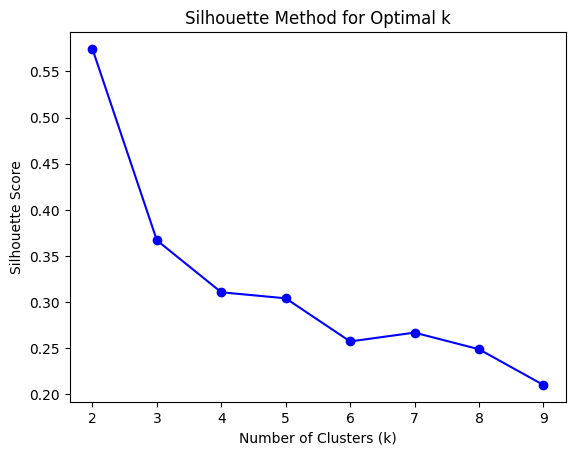

In [ ]:
#Finding number of clusters using Silhouette score
sil_scores = []
K_range = range(2, 10)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

plt.plot(K_range, sil_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [ ]:
# Using k-means for clustering
n_clusters = 2 #Based on Silhouette  method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
train["cluster"] = kmeans.fit_predict(X)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


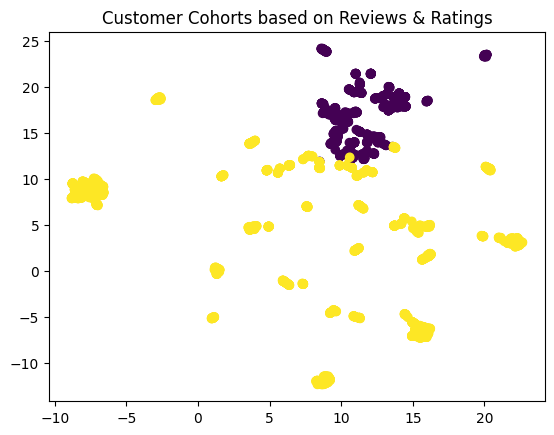

In [ ]:
# Using UMAP Reduction technique for visualization
reducer = umap.UMAP(n_neighbors=20, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(X)

#Scatter plot
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=train["cluster"], cmap="viridis")
plt.title("Customer Cohorts based on Reviews & Ratings")
plt.show()

In [ ]:
# Using Silhouette score for evaluation. This will measure how well seperated clusters are.
score = silhouette_score(X, train["cluster"])
print(f"Silhouette Score: {score:.3f}")

Silhouette Score: 0.574


In [ ]:
#Using Davies–Bouldin Index. This will measure average similarity between clusters.
db_index = davies_bouldin_score(X, train["cluster"])
print(f"Davies–Bouldin Index: {db_index:.3f}")

Davies–Bouldin Index: 0.662


In [ ]:
# Inspecting cluster points
for c in range(n_clusters):
    print(f"\nCluster {c}:")
    sample = train[train["cluster"] == c]
    print(sample["Rating"].describe())
    print(sample["Effectiveness_Rating"].describe())
    print(sample["Side_Effects_Rating"].describe())
    print(sample["Overall_Review"].head(3))


Cluster 0:
count    823.000000
mean       2.667072
std        1.570244
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        6.000000
Name: Rating, dtype: float64
count    823.000000
mean       3.415553
std        1.356197
min        1.000000
25%        2.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: Effectiveness_Rating, dtype: float64
count    823.000000
mean       3.482382
std        1.182545
min        1.000000
25%        3.000000
50%        4.000000
75%        4.000000
max        5.000000
Name: Side_Effects_Rating, dtype: float64
0    monitor blood pressure , weight and asses for ...
1    I Hate This Birth Control, I Would Not Suggest...
3    I was given Prilosec prescription at a dose of...
Name: Overall_Review, dtype: object

Cluster 1:
count    2284.000000
mean        8.569615
std         1.272701
min         5.000000
25%         8.000000
50%         9.000000
75%        10.000000
max        10.000000
Name: Rating,

# Cohorts of customers with similar reviews and ratings:

#### Cluster 0: Customers in this group find the medicine barely effective but highly uncomfortable due to side effects.

#### Cluster 1: This group perceives the medicine as very effective, with mild side effects
